# Detector Rates
The purpose of this notebook is to determine the relationship between bin values and actual energies.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import lmfit as lf
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as interp

In [2]:
#Import data
dataPuBe = pd.read_csv ("data/PuBe_stepsize136_30ssteps.csv")
dataNa22 = pd.read_csv ("data/22Na_stepsize136_30ssteps.csv")
thrsPuBe = dataPuBe.iloc[:,0]
thrsNa22 = dataNa22.iloc[:,0]
ratePuBe = dataPuBe.iloc[:,1]
rateNa22 = dataNa22.iloc[:,1]

#Cut an ill-behaved region
ratePuBe = ratePuBe[thrsPuBe > 220]
rateNa22 = rateNa22[thrsNa22 > 220]
thrsPuBe = thrsPuBe[thrsPuBe > 220]
thrsNa22 = thrsNa22[thrsNa22 > 220]

del dataPuBe, dataNa22

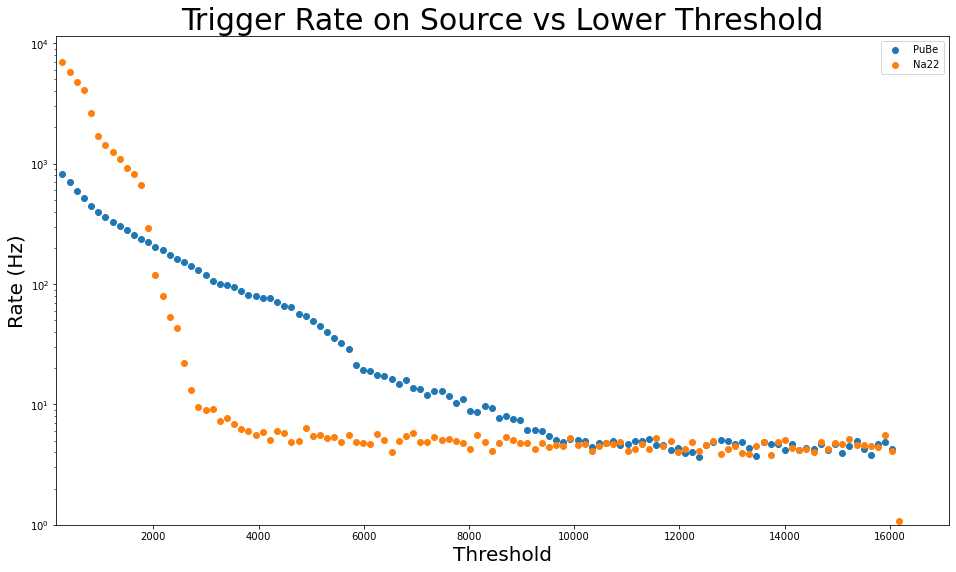

In [3]:
plt.figure(figsize=(16,9))

plt.scatter(thrsPuBe,ratePuBe,label="PuBe")
plt.scatter(thrsNa22,rateNa22,label="Na22")

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Trigger Rate on Source vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.yscale('log')
plt.xlim(150)
plt.ylim(1)

plt.legend()
plt.show()

In [4]:
diffsPuBe = np.zeros(len(thrsPuBe))
dfthPuBe  = np.zeros(len(dfthPuBe))
for i,n in enumerate(ratePuBe):
    try:
        diffsPuBe[i] = ratePuBe[i-1] - n
    except KeyError:
        diffsPuBe[i] = np.nan
dfthPuBe = thrsPuBe-0.5
diffsNa22 = np.zeros(len(thrsNa22))
for i,n in enumerate(rateNa22):
    try:
        diffsNa22[i] = rateNa22[i-1] - n
    except KeyError:
        diffsNa22[i] = np.nan
dfthNa22 = thrsNa22-0.5

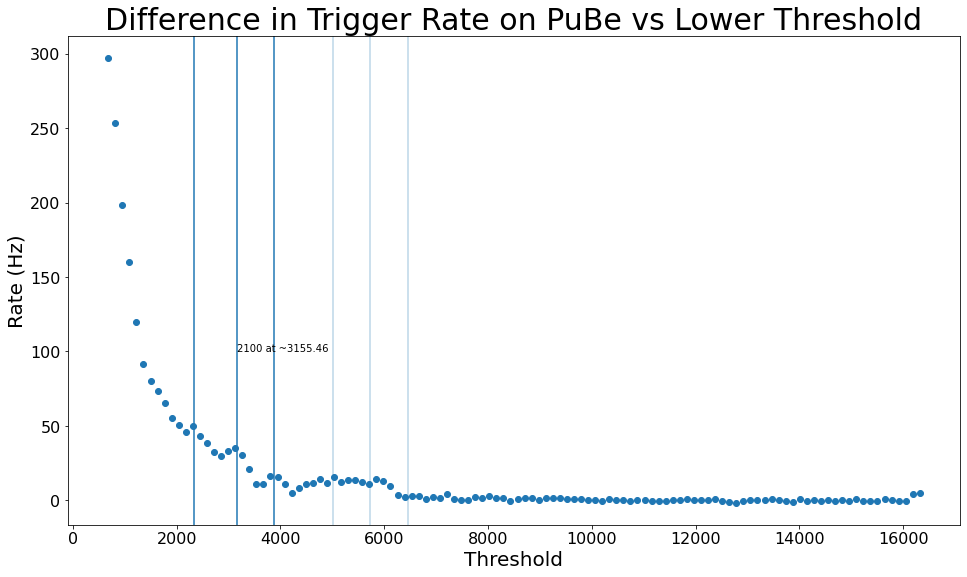

In [5]:
plt.figure(figsize=(16,9))

plt.scatter(dfthPuBe,diffsPuBe,label="PuBe")

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Difference in Trigger Rate on PuBe vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
#plt.xlim(5000)
#plt.ylim(0)

def f(x):
    return (x + 140.38)/0.71
    #return 0.71*x-140.38 #backwards!

plt.axvline(2340)
plt.axvline(f(2100))
plt.text(f(2100),100,"2100 at ~{:.2f}".format(f(2100)))
plt.axvline(f(2615))
plt.axvline(f(4438-511*2),alpha=0.3)
plt.axvline(f(4438-511),alpha=0.3)
plt.axvline(f(4438),alpha=0.3)

plt.show()

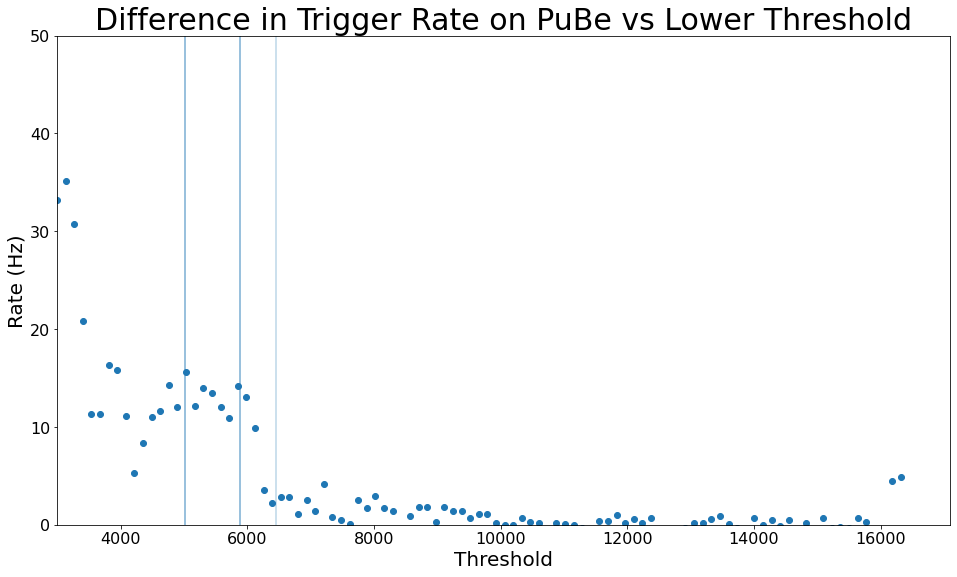

In [6]:
plt.figure(figsize=(16,9))

plt.scatter(dfthPuBe,diffsPuBe,label="PuBe")

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Difference in Trigger Rate on PuBe vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim(3000)
plt.ylim(0,50)

plt.axvline(f(4438-511*2),alpha=0.6)
plt.axvline(5880,alpha=0.6)
plt.axvline(f(4438),alpha=0.3)

plt.show()

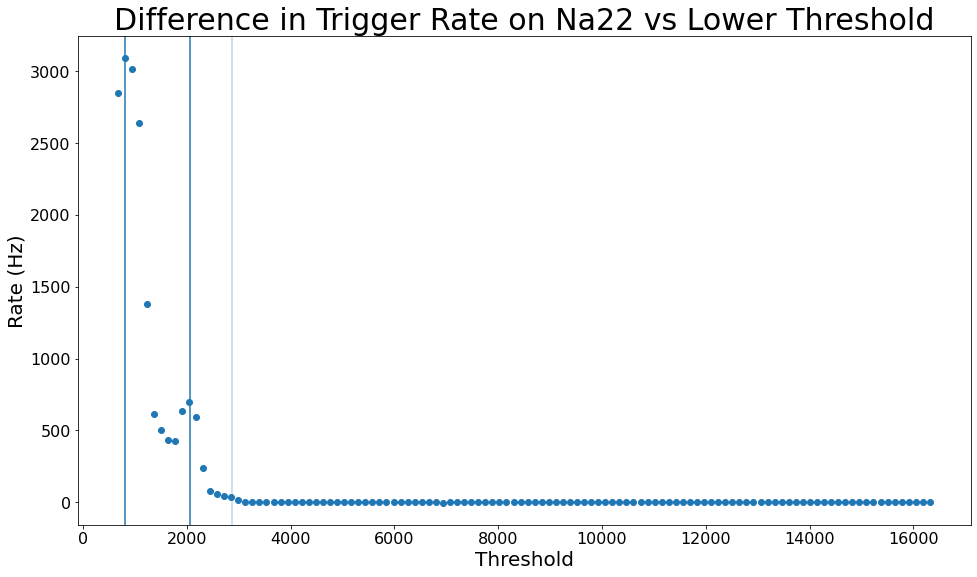

In [7]:
plt.figure(figsize=(16,9))

plt.scatter(dfthNa22,diffsNa22)

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Difference in Trigger Rate on Na22 vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
#plt.xlim(5000)
#plt.ylim(0)

plt.axvline(800)
plt.axvline(2068)
plt.axvline(800+2068,alpha=0.3)

plt.show()

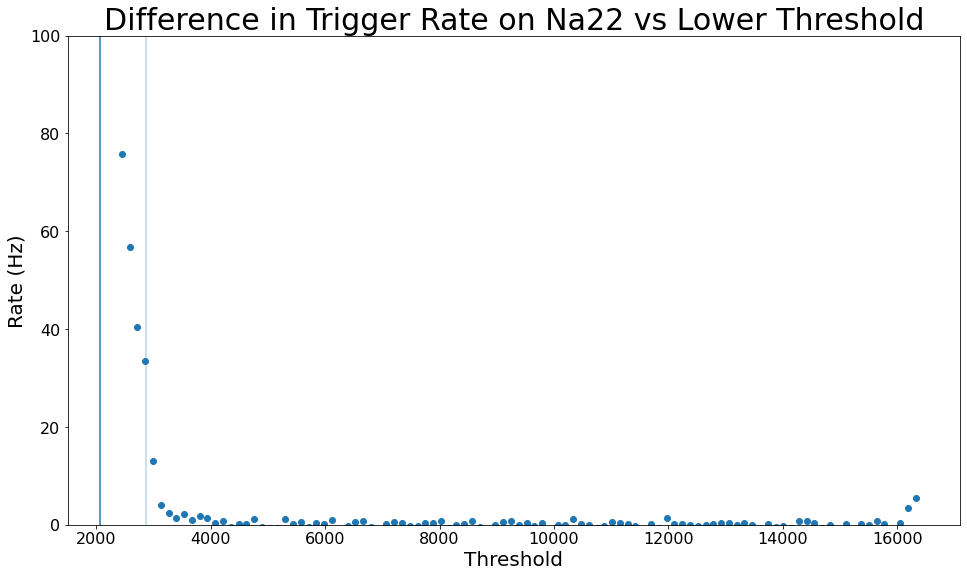

In [8]:
plt.figure(figsize=(16,9))

plt.scatter(thrsNa22,diffsNa22)

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Difference in Trigger Rate on Na22 vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim(1500)
plt.ylim(0,100)

plt.axvline(800)
plt.axvline(2068)
plt.axvline(800+2068,alpha=0.3)

plt.show()

## Fitting the Bin/Energy Relationship
Note that we are only "fitting" to two points (drawing a line between them) as a rudimentary measure. This is partially due to the fact that the third point is not very clear, being both short and wide.

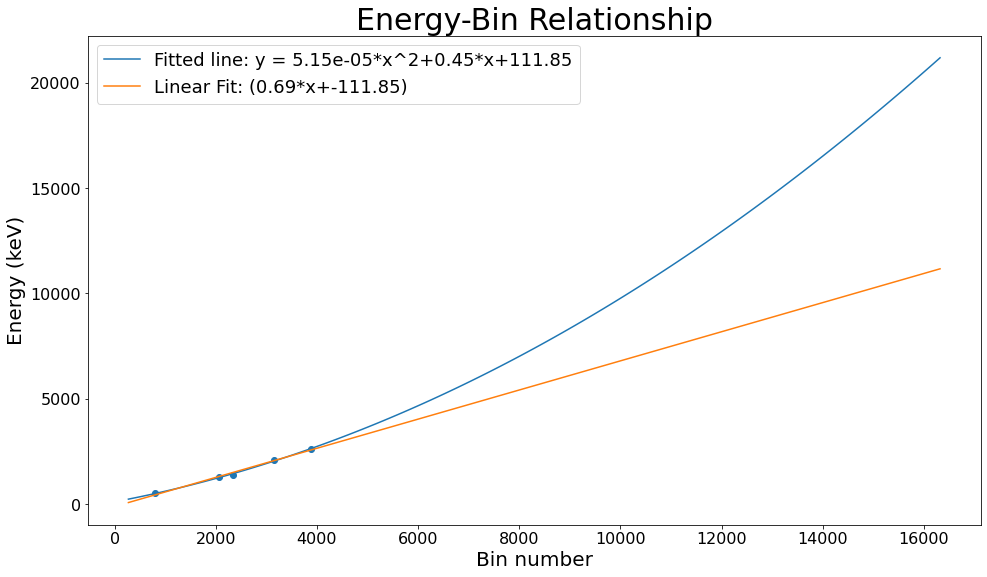

In [9]:
#Set up our model
def f_quad(x,a,b,c):
    return a*x**2+b*x+c
l_model = lf.Model(f_quad)
params = l_model.make_params(a=0,b=1,c=0) #Use our old 'fit' for inital guesses.


binpoints = [800,2068,2340,f(2100),f(2615)]
energypoints = [511,1274,1400,2100,2615]

#Do the fit
l_fit = l_model.fit(energypoints,params,x=binpoints)
l_dict = l_fit.best_values
l_a = l_dict['a']
l_b = l_dict['b']
l_c = l_dict['c']
l_curve = f_quad(thrsNa22,l_a,l_b,l_c)

def f_linear(x,m,b):
    return m*x+b
lin_mod = lf.Model(f_linear)
lin_params = lin_mod.make_params(m=0,b=0)

#Do the fit
lin_fit = lin_mod.fit(energypoints,lin_params,x=binpoints)
lin_dict = lin_fit.best_values
lin_m = lin_dict['m']
lin_b = lin_dict['b']

#plot it
plt.figure(figsize=(16,9))
plt.scatter(binpoints,energypoints)
plt.plot(thrsNa22,l_curve,label="Fitted line: y = {:.2e}*x^2+{:.2f}*x+{:.2f}".format(l_a,l_b,l_c))
plt.plot(thrsNa22,lin_m*thrsNa22+lin_b,label="Linear Fit: ({:.2f}*x+{:.2f})".format(lin_m,lin_b))
plt.title("Energy-Bin Relationship",fontsize=30)
plt.xlabel("Bin number",fontsize=20)
plt.ylabel("Energy (keV)",fontsize=20)
plt.legend(fontsize=18)
plt.show()

l_fit

In [10]:
lin_fit

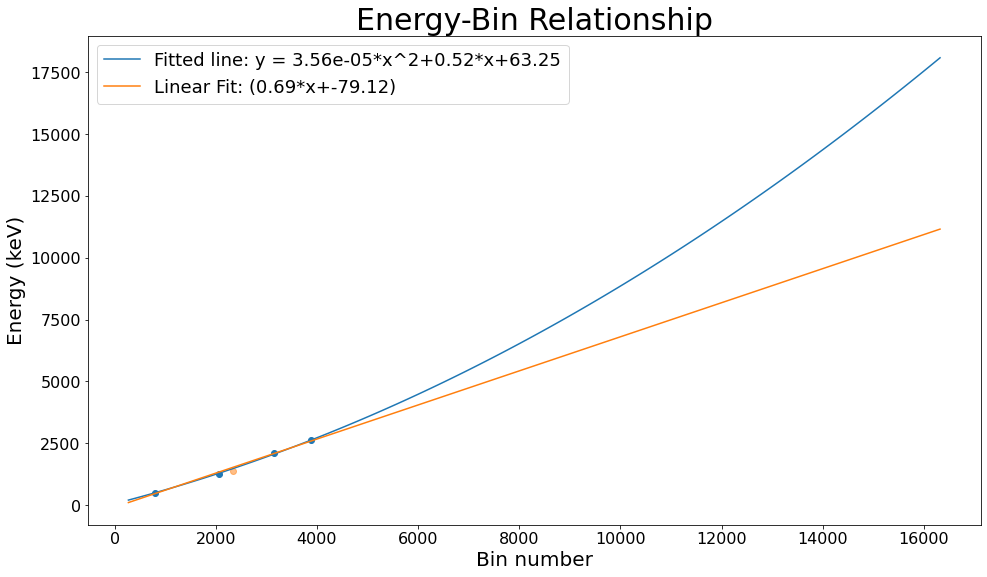

In [11]:
#Set up our model
def f_quad(x,a,b,c):
    return a*x**2+b*x+c
l_model = lf.Model(f_quad)
params = l_model.make_params(a=0,b=1,c=0) #Use our old 'fit' for inital guesses.


binpoints = [800,2068,f(2100),f(2615)]
energypoints = [511,1274,2100,2615]

#Do the fit
l_fit = l_model.fit(energypoints,params,x=binpoints)
l_dict = l_fit.best_values
l_a = l_dict['a']
l_b = l_dict['b']
l_c = l_dict['c']
l_curve = f_quad(thrsNa22,l_a,l_b,l_c)

def f_linear(x,m,b):
    return m*x+b
lin_mod = lf.Model(f_linear)
lin_params = lin_mod.make_params(m=0,b=0)

#Do the fit
lin_fit = lin_mod.fit(energypoints,lin_params,x=binpoints)
lin_dict = lin_fit.best_values
lin_m = lin_dict['m']
lin_b = lin_dict['b']

#plot it
plt.figure(figsize=(16,9))
plt.scatter(binpoints,energypoints)
plt.scatter(2340,1400,alpha=0.5)
plt.plot(thrsNa22,l_curve,label="Fitted line: y = {:.2e}*x^2+{:.2f}*x+{:.2f}".format(l_a,l_b,l_c))
plt.plot(thrsNa22,lin_m*thrsNa22+lin_b,label="Linear Fit: ({:.2f}*x+{:.2f})".format(lin_m,lin_b))
plt.title("Energy-Bin Relationship",fontsize=30)
plt.xlabel("Bin number",fontsize=20)
plt.ylabel("Energy (keV)",fontsize=20)
plt.legend(fontsize=18)
plt.show()

l_fit

In [12]:
lin_fit